In [21]:
from parser import get_files_in_folder, parse_gene_sequences
from damerau_levenshtein import damerau_levenshtein
from gen_algo import crossover, mutate

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

import os, sys

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from keras.utils import to_categorical

In [24]:
dataset = pd.read_csv('dataset copy.csv', sep=';')

x = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

In [25]:
pca = PCA(n_components=0.95)
x_pca = pca.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_pca)

In [26]:
# implementing silhoutte score
params = [2, 3, 4, 5, 6, 7, 8, 9, 10]
paramGrid = ParameterGrid({'n_clusters': params})

best_score = -1

silhouette_scores = []

kmeans = KMeans()

for p in paramGrid:
	kmeans.set_params(**p)
	kmeans.fit(x)

	silScore = silhouette_score(x, kmeans.labels_, random_state=0)
	silhouette_scores.append(silScore)

	print('Parameter: ', p, 'Score: ', silScore)

	if silScore > best_score:
		best_score = silScore
		best_grid = p

Parameter:  {'n_clusters': 2} Score:  0.9448229754500729
Parameter:  {'n_clusters': 3} Score:  0.8119256926371791
Parameter:  {'n_clusters': 4} Score:  0.7976727394392674
Parameter:  {'n_clusters': 5} Score:  0.7938383293105705
Parameter:  {'n_clusters': 6} Score:  0.8542824503880959
Parameter:  {'n_clusters': 7} Score:  0.8568496335473295
Parameter:  {'n_clusters': 8} Score:  0.8568081718589916
Parameter:  {'n_clusters': 9} Score:  0.8578966998636256
Parameter:  {'n_clusters': 10} Score:  0.8575562998420415


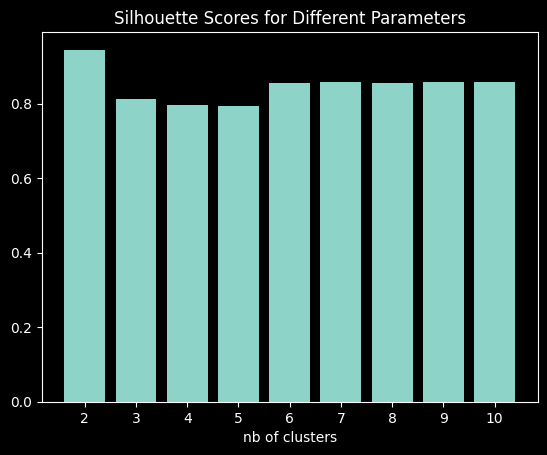

In [27]:

# plot the silhouette scores
plt.bar(range(len(silhouette_scores)), silhouette_scores, tick_label=list(params))
plt.xticks(range(len(silhouette_scores)), params)
plt.title('Silhouette Scores for Different Parameters')
plt.xlabel('nb of clusters')

plt.show()

Best grid:  2 Best score:  0.9448229754500729


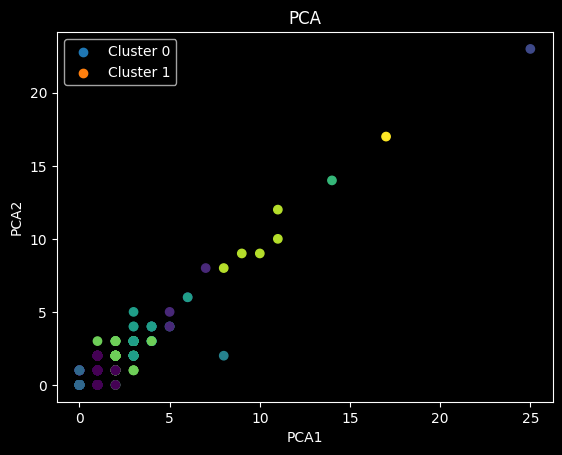

In [28]:
print('Best grid: ', best_grid['n_clusters'], 'Best score: ', best_score)

y_pred = KMeans(n_clusters=best_grid['n_clusters'], random_state=0).fit_predict(x)

km = KMeans(n_clusters=best_grid['n_clusters'], random_state=0).fit(x)
y_kmeans = km.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_)

# legend
for i in range(best_grid['n_clusters']):
	plt.scatter([], [], color=plt.cm.tab10(i), label=f'Cluster {i}')
plt.legend()

plt.title('PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

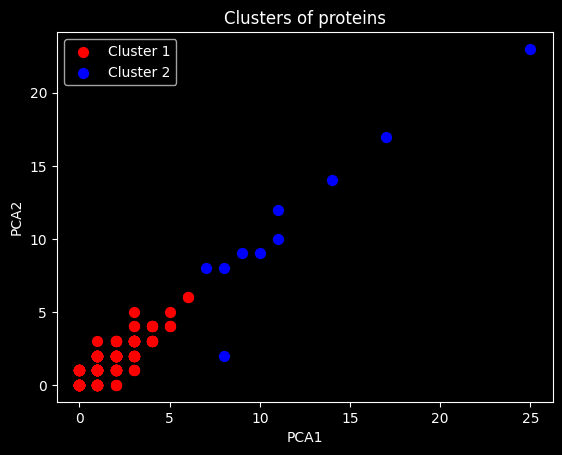

Number of points in each cluster:
Cluster 0: 2723 points
Cluster 1: 10 points


In [34]:
# ax = plt.gca()
# ax.set_xlim([-200, 450])
# ax.set_ylim([-100, 80])

plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s=50, c='red', label='Cluster 1')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s=50, c='blue', label='Cluster 2')
# name the axes
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters of proteins')
plt.legend()

plt.show()

# print the number of points in each cluster
unique, counts = np.unique(y_kmeans, return_counts=True)
print("Number of points in each cluster:")
for i, count in zip(unique, counts):
    print(f"Cluster {i}: {count} points")
    

In [43]:
hdb = HDBSCAN()
hdb.fit(x)
hdb_labels = hdb.labels_

Max number of clusters found by HDBSCAN:  26


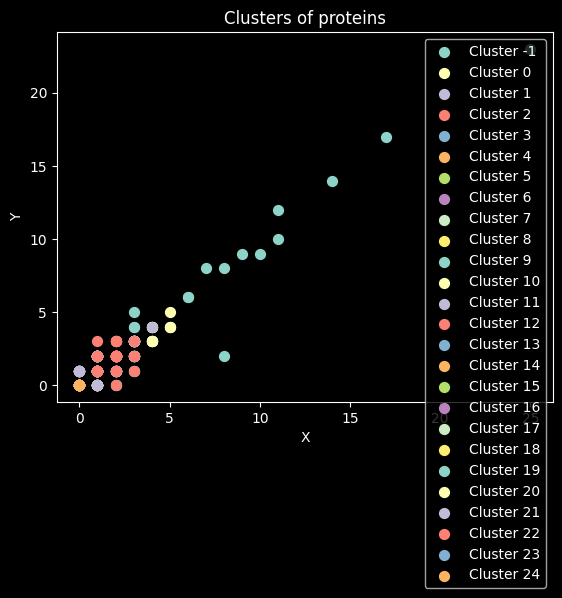

In [44]:
# print max number of clusters found by HDBSCAN
print('Max number of clusters found by HDBSCAN: ', len(np.unique(hdb_labels)))

# ax = plt.gca()
# ax.set_ylim([-10, 20])
# ax.set_xlim([-10, 20])

for i in np.unique(hdb_labels):
	plt.scatter(x[hdb_labels == i, 0], x[hdb_labels == i, 1], s=50, label='Cluster ' + str(i))

plt.legend()

plt.title('Clusters of proteins')
plt.xlabel('X')
plt.ylabel('Y')

# plt.legend()
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5586 (21.82 KB)
Trainable params: 5586 (21

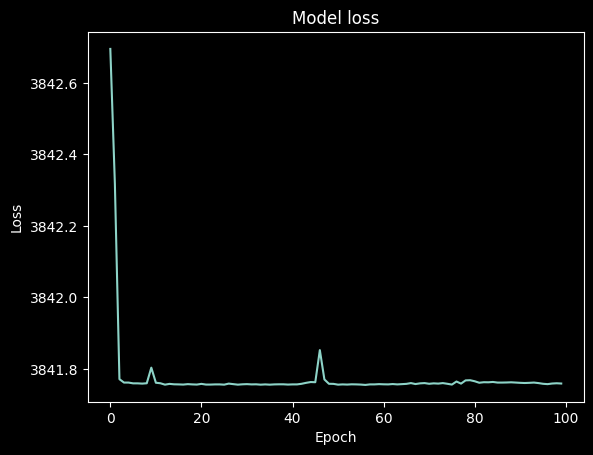

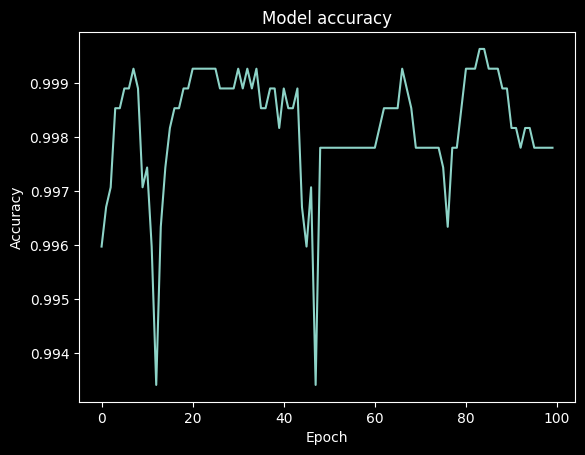

In [36]:
# Définir un modèle autoencodeur pour le clustering
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_pca.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(x_pca.shape[1], activation='sigmoid'))

# Compiler le modèle avec une fonction de perte adaptée
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()
                                                                       
# Entraînement du modèle (Autoencodeur)
history = model.fit(x_pca, x_pca, epochs=100, batch_size=16, verbose=0)

# Afficher l'évolution de la fonction de perte
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

# Afficher l'évolution de la précision
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

In [37]:
# clustering
encoder = Sequential()
encoder.add(model.layers[0])
encoder.add(model.layers[1])
encoder.add(model.layers[2])

X_encoded = encoder.predict(x_pca)

86/86 [==============================] - 0s 753us/step


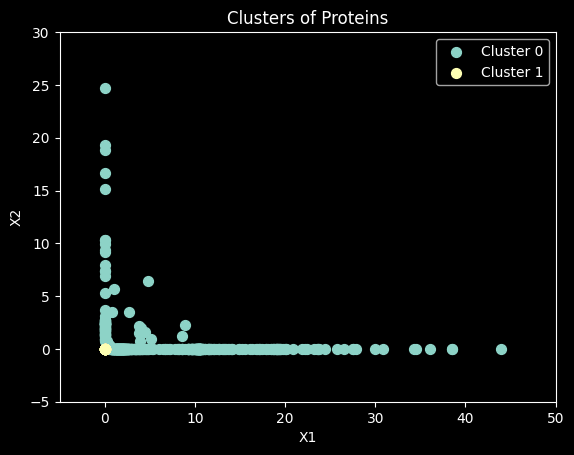

In [38]:
# clustering
kmeans = KMeans(n_clusters=2, random_state=0)
y_pred = kmeans.fit_predict(X_encoded)

ax = plt.gca()
ax.set_xlim([-5, 50])
ax.set_ylim([-5, 30])

# Afficher les résultats du clustering
for i in range(2):
	plt.scatter(X_encoded[y_pred == i, 0], X_encoded[y_pred == i, 1], s=50, label='Cluster ' + str(i))

plt.title('Clusters of Proteins')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()

plt.show()

Max number of clusters found by HDBSCAN:  11


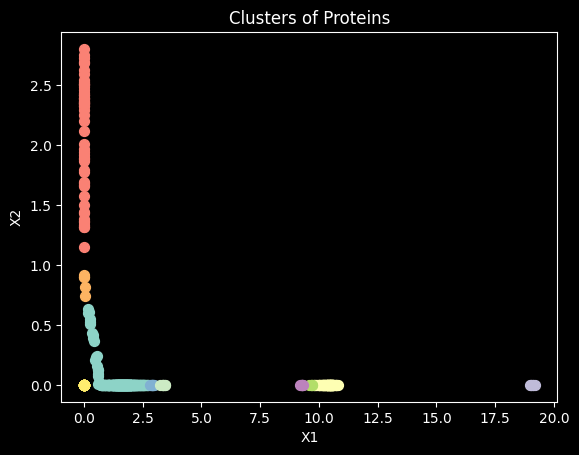

In [46]:
dbscan_2 = DBSCAN(min_samples=5)
dbscan_labels_2 = dbscan_2.fit_predict(X_encoded)

# print max number of clusters found by DBSCAN
print('Max number of clusters found by HDBSCAN: ', len(np.unique(dbscan_labels_2)))

# ax = plt.gca()
# ax.set_xlim([-20, 50])
# ax.set_ylim([-30, 20])

for i in range(len(np.unique(dbscan_labels_2))):
	plt.scatter(X_encoded[dbscan_labels_2 == i, 0], X_encoded[dbscan_labels_2 == i, 1], s=50, label='Cluster ' + str(i))

plt.title('Clusters of Proteins')
plt.xlabel('X1')
plt.ylabel('X2')
# plt.legend()
plt.show()